In [1]:
%%capture
# Redirects the current working directory to the project directory
%cd ..

In [2]:
%load_ext tensorboard

In [3]:
from src.model import RBN
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X_dataset = np.load('raw/X_dataset.npy')
y_dataset = np.load('raw/y_dataset.npy')

In [5]:
print(X_dataset.shape)
print(y_dataset.shape)

(246, 84, 21)
(246, 28, 1)


In [6]:
RBN_model = RBN('RBN-oneshot-rev-1.2', t=84, k=21, H=28, units=200)


In [7]:
# RBN_model.load_weights('logs/weights/' + RBN_model.name)
RBN_model.normalize.adapt(X_dataset)

In [8]:
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.optimizers import Adam

tf_rmse = rmse(name='rmse')
tf_adam = Adam(learning_rate = 0.001, name='Adam')

RBN_model.compile(optimizer=tf_adam, loss='mse', metrics=["mae", tf_rmse])

In [9]:
log_directory = 'logs/fit/' + RBN_model.name
tb_callback = TensorBoard(log_dir=log_directory, histogram_freq=1)

In [10]:
RBN_model.fit(X_dataset, y_dataset,
              batch_size=1, epochs=300,
              callbacks=[tb_callback],
              validation_split=0.2,
              verbose=0)

In [11]:
RBN_model.summary()

Model: "RBN-oneshot-rev-1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalizer (Normalization)  multiple                  43        
                                                                 
 Encoder (LSTM)              multiple                  48800     
                                                                 
 Decoder (Dense)             multiple                  2828      
                                                                 
Total params: 51,671
Trainable params: 51,628
Non-trainable params: 43
_________________________________________________________________


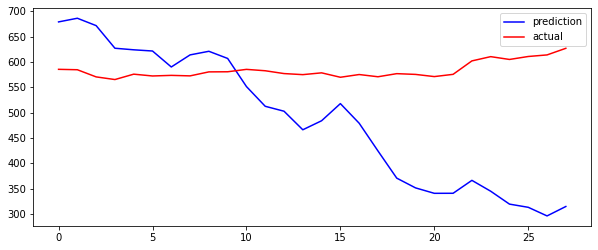

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
test_points = RBN_model(X_dataset, training=False)
ax.plot(test_points[20].numpy().reshape(-1), color='b', label='prediction')
ax.plot(y_dataset[20], color='r', label='actual')

# ax.set_yscale('log')
ax.legend()

In [13]:
test_points[230].numpy()

array([8185.908 , 8150.439 , 8114.5957, 8081.107 , 7954.3037, 7966.91  ,
       7840.4424, 7894.747 , 7812.153 , 7742.7827, 7685.288 , 7523.738 ,
       7489.955 , 7344.31  , 7401.6226, 7390.2456, 7253.9966, 7183.645 ,
       6948.127 , 6865.698 , 6727.7793, 6752.972 , 6809.8403, 6670.6426,
       6631.276 , 6526.5977, 6450.795 , 6392.0923], dtype=float32)

In [14]:
RBN_model.save_weights('logs/weights/' + RBN_model.name)